In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # setup đường dẫn

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

In [2]:
input_path = "../data/raw/Global_Landslide_Catalog_Export.csv"
df = pd.read_csv(input_path)
df.head()

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
0,AGU,https://blogs.agu.org/landslideblog/2008/10/14...,684,08/01/2008 12:00:00 AM,NaN,"Sigou Village, Loufan County, Shanxi Province","occurred early in morning, 11 villagers buried...","Sigou Village, Loufan County, Shanxi Province",unknown,landslide,...,CN,Shaanxi,0.0,Jingyang,41.02145,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,107.4500,32.5625
1,Oregonian,http://www.oregonlive.com/news/index.ssf/2009/...,956,01/02/2009 02:00:00 AM,NaN,"Lake Oswego, Oregon",Hours of heavy rain are to blame for an overni...,"Lake Oswego, Oregon",5km,mudslide,...,US,Oregon,36619.0,Lake Oswego,0.60342,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-122.6630,45.4200
2,CBS News,https://www.cbsnews.com/news/dozens-missing-af...,973,01/19/2007 12:00:00 AM,NaN,"San Ramon district, 195 miles northeast of the...",(CBS/AP) At least 10 people died and as many a...,"San Ramon district, 195 miles northeast of the...",10km,landslide,...,PE,Junín,14708.0,San Ramón,0.85548,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-75.3587,-11.1295
3,Reuters,https://in.reuters.com/article/idINIndia-41450...,1067,07/31/2009 12:00:00 AM,NaN,Dailekh district,"One person was killed in Dailekh district, pol...",Dailekh district,unknown,landslide,...,NP,Mid Western,20908.0,Dailekh,0.75395,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,81.7080,28.8378
4,The Freeman,http://www.philstar.com/cebu-news/621414/lands...,2603,10/16/2010 12:00:00 PM,NaN,sitio Bakilid in barangay Lahug,Another landslide in sitio Bakilid in barangay...,sitio Bakilid in barangay Lahug,5km,landslide,...,PH,Central Visayas,798634.0,Cebu City,2.02204,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,123.8978,10.3336


**Câu hỏi 3 (Đình Trí): Trong các đơn vị hành chính có dân số cao, những tháng nào ghi nhận nhiều vụ sạt lở nhất và các vụ sạt lở trong những tháng này gây ra mức độ thiệt hại về con người (tử vong và bị thương) ra sao?**

In [3]:
# --- Chuyển cột event_date sang datetime ---
df['event_date'] = pd.to_datetime(df['event_date'], format='mixed', dayfirst=False, errors='coerce')

# --- Xử lý Missing Values cho thương vong (NaN -> 0) ---
cols_impact = ['fatality_count', 'injury_count']
df[cols_impact] = df[cols_impact].fillna(0)

# --- Loại bỏ các dòng thiếu thông tin quan trọng ---
df_clean = df.dropna(subset=['event_date', 'admin_division_population'])
print("Số dòng còn lại của bộ dữ liệu sau khi loại bỏ là:", df_clean.shape[0])

Số dòng còn lại của bộ dữ liệu sau khi loại bỏ là: 9471


In [4]:
# --- Lọc khu vực "Dân số cao" ---
# Tính ngưỡng dân số (Top 25% cao nhất)
pop_threshold = df_clean['admin_division_population'].quantile(0.75)
print(f"Dân số cao sẽ có số lượng lớn hơn {pop_threshold} người")
# Lọc dữ liệu
df_high_pop = df_clean[df_clean['admin_division_population'] >= pop_threshold].copy()
print(f"Số lượng bản ghi sau khi lọc: {len(df_high_pop)}")
# --- Trích xuất tháng ---
df_high_pop['month'] = df_high_pop['event_date'].dt.month

Dân số cao sẽ có số lượng lớn hơn 34021.0 người
Số lượng bản ghi sau khi lọc: 2370


In [5]:
# --- Tạo biến tổng thiệt hại cho con người ---
#df_high_pop['sum_human_casualty'] = (df_high_pop['fatality_count'] + df_high_pop['injury_count'])
#print(df_high_pop[['admin_division_name','admin_division_population',
                 #  'month','fatality_count','injury_count','sum_human_casualty']].head())

   admin_division_name  admin_division_population  month  fatality_count  \
1               Oregon                    36619.0      1             0.0   
4      Central Visayas                   798634.0     10             0.0   
10              Yunnan                  1023674.0     11             4.0   
15              Oregon                   583776.0      1             0.0   
24               Jijel                   148000.0      1             6.0   

    injury_count  sum_human_casualty  
1            0.0                 0.0  
4            0.0                 0.0  
10           0.0                 4.0  
15           0.0                 0.0  
24           0.0                 6.0  


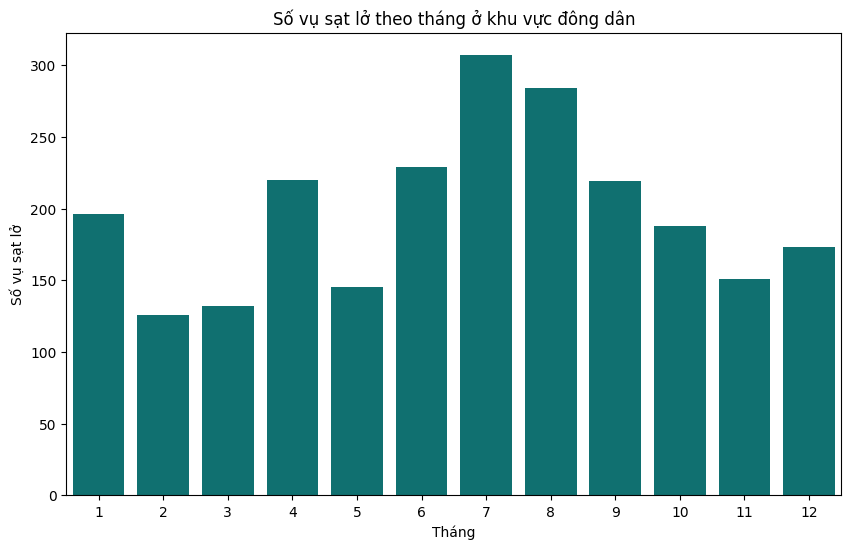

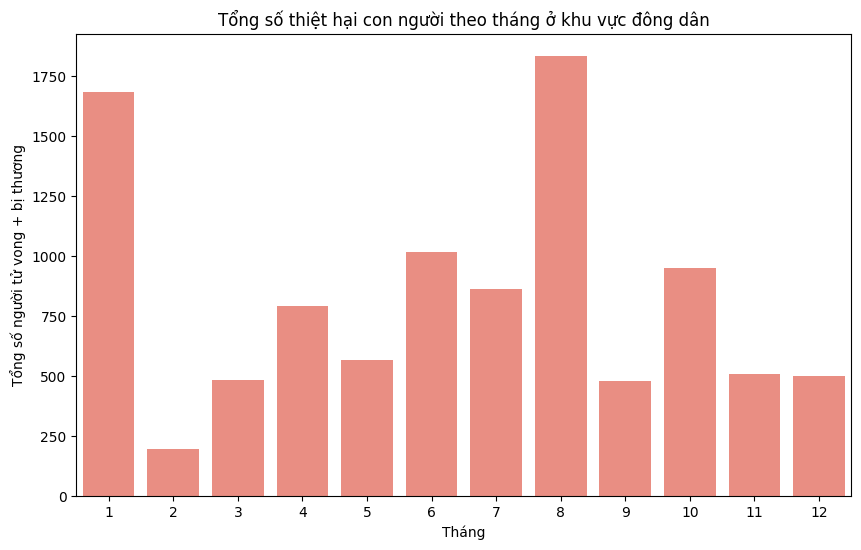

C:\Users\Administrator\AppData\Local\Temp\ipykernel_256\437658922.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_high_pop, x='month', y='sum_human_casualty', palette='Pastel1')


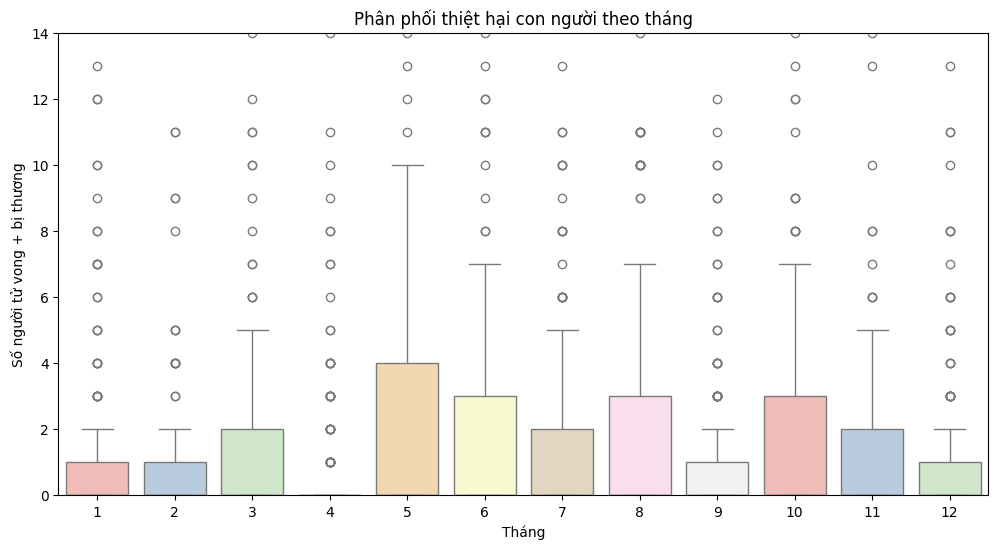

In [10]:


# --- 1. Đếm số vụ sạt lở theo tháng ---
monthly_counts = df_high_pop.groupby('month').size().reset_index(name='num_landslides')

# Bar chart số vụ sạt lở theo tháng
plt.figure(figsize=(10,6))
sns.barplot(data=monthly_counts, x='month', y='num_landslides', color='teal')
plt.title("Số vụ sạt lở theo tháng ở khu vực đông dân")
plt.xlabel("Tháng")
plt.ylabel("Số vụ sạt lở")
plt.show()

# --- 2. Tổng và trung bình human_casualty theo tháng ---
monthly_stats = df_high_pop.groupby('month')['sum_human_casualty'].agg(
    total_casualty='sum', mean_casualty='mean').reset_index()
# 1. Gom nhóm theo tháng và tính toán
#
monthly_stats = df_high_pop.groupby('month').agg({
    'event_date': 'count',          # Đếm số vụ
    'fatality_count': 'sum',        # Tổng số chết
    'injury_count': 'sum'           # Tổng số bị thương
}).rename(columns={'event_date': 'event_count'})

# 2. Tạo cột tổng thương vong
monthly_stats['total_casualties'] = (
    monthly_stats['fatality_count'] + monthly_stats['injury_count']
)
#
# Bar chart tổng thiệt hại con người theo tháng
plt.figure(figsize=(10,6))
sns.barplot(data=monthly_stats, x='month', y='total_casualty', color='salmon')
plt.title("Tổng số thiệt hại con người theo tháng ở khu vực đông dân")
plt.xlabel("Tháng")
plt.ylabel("Tổng số người tử vong + bị thương")
plt.show()

# --- 3. Boxplot sum_human_casualty theo tháng ---
plt.figure(figsize=(12,6))
sns.boxplot(data=df_high_pop, x='month', y='sum_human_casualty', palette='Pastel1')
plt.title("Phân phối thiệt hại con người theo tháng")
plt.xlabel("Tháng")
plt.ylabel("Số người tử vong + bị thương")
plt.ylim(0, df_high_pop['sum_human_casualty'].quantile(0.95)) # cắt outlier cực đoan
plt.show()


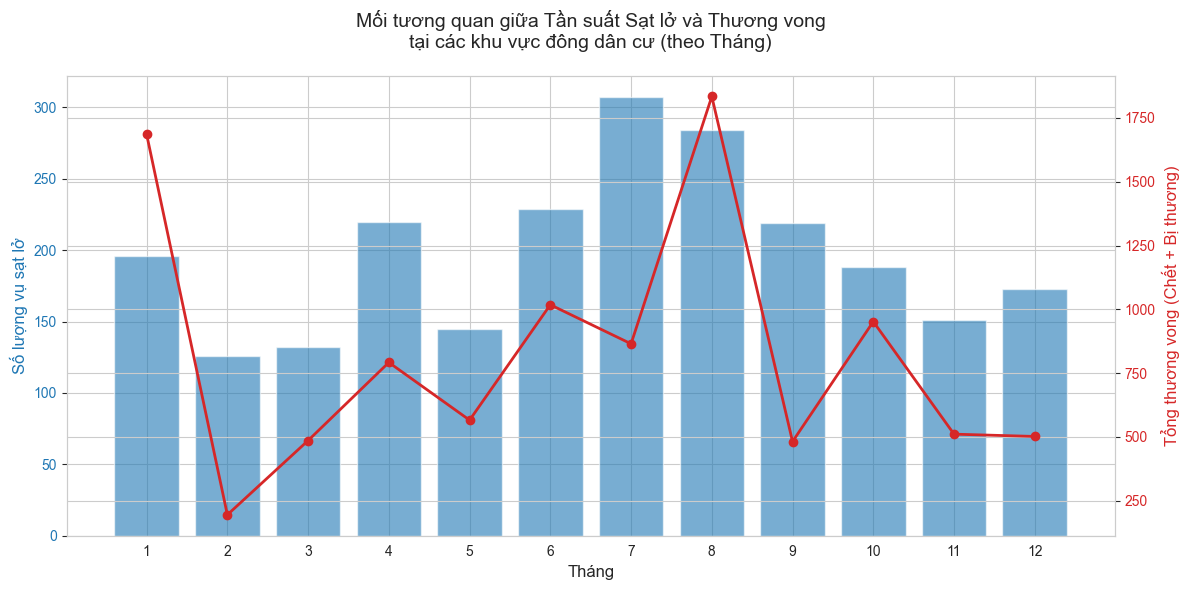

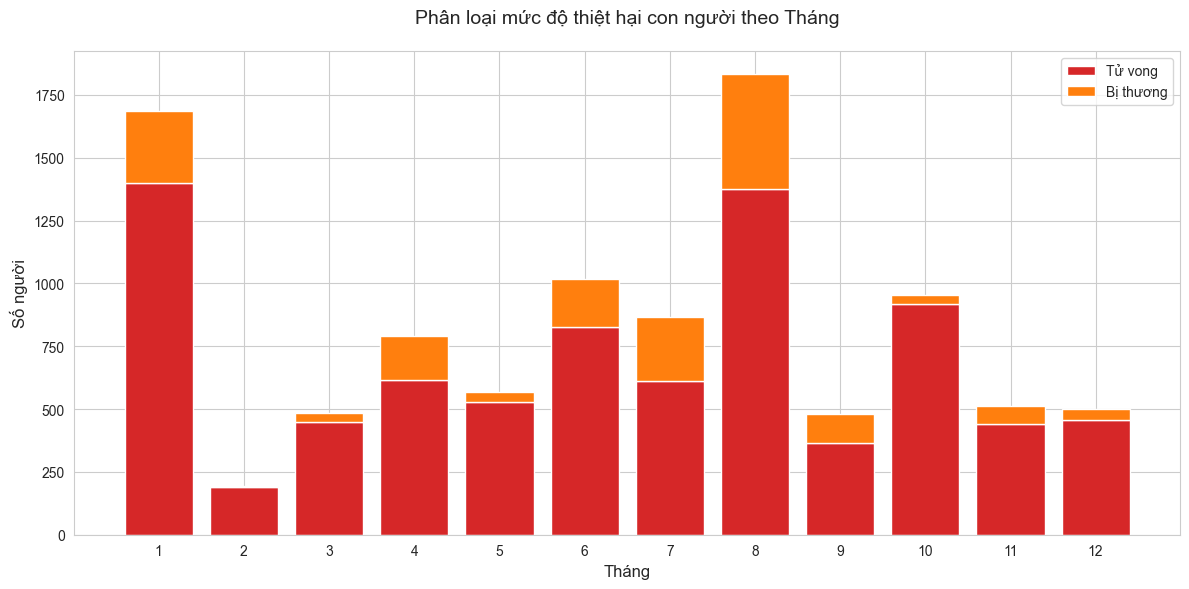

In [13]:
def analyze_monthly_impact(df_high_pop):
    # 1. Gom nhóm theo tháng và tính toán
    monthly_stats = df_high_pop.groupby('month').agg({
        'event_date': 'count',          # Đếm số vụ
        'fatality_count': 'sum',        # Tổng số chết
        'injury_count': 'sum'           # Tổng số bị thương
    }).rename(columns={'event_date': 'event_count'})

    # 2. Tạo cột tổng thương vong
    monthly_stats['total_casualties'] = (
        monthly_stats['fatality_count'] + monthly_stats['injury_count']
    )
    
    # Sắp xếp index để đảm bảo tháng chạy từ 1 đến 12
    monthly_stats = monthly_stats.sort_index()
    
    return monthly_stats

# Thực hiện phân tích
monthly_stats = analyze_monthly_impact(df_high_pop)

# --- PHẦN VẼ BIỂU ĐỒ ---

def visualize_results(monthly_stats):
    sns.set_style("whitegrid")
    months = monthly_stats.index
    
    # === BIỂU ĐỒ 1: Tần suất Sạt lở vs Tổng Thương vong (2 trục) ===
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Trục 1 (Cột): Số lượng vụ sạt lở
    color = 'tab:blue'
    ax1.set_xlabel('Tháng', fontsize=12)
    ax1.set_ylabel('Số lượng vụ sạt lở', color=color, fontsize=12)
    ax1.bar(months, monthly_stats['event_count'], color=color, alpha=0.6, label='Số vụ')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(months)

    # Trục 2 (Đường): Tổng thương vong
    ax2 = ax1.twinx()  # Tạo trục y thứ 2 dùng chung trục x
    color = 'tab:red'
    ax2.set_ylabel('Tổng thương vong (Chết + Bị thương)', color=color, fontsize=12)
    ax2.plot(months, monthly_stats['total_casualties'], color=color, 
             marker='o', linewidth=2, linestyle='-', label='Thương vong')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Mối tương quan giữa Tần suất Sạt lở và Thương vong\ntại các khu vực đông dân cư (theo Tháng)', 
              fontsize=14, pad=20)
    fig.tight_layout()
    plt.show()

    # === BIỂU ĐỒ 2: Thành phần thương vong (Chết vs Bị thương) ===
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Vẽ biểu đồ chồng (Stacked Bar)
    p1 = plt.bar(months, monthly_stats['fatality_count'], color='#d62728', label='Tử vong')
    p2 = plt.bar(months, monthly_stats['injury_count'], 
                 bottom=monthly_stats['fatality_count'], # Chồng lên cột tử vong
                 color='#ff7f0e', label='Bị thương')

    plt.xlabel('Tháng', fontsize=12)
    plt.ylabel('Số người', fontsize=12)
    plt.title('Phân loại mức độ thiệt hại con người theo Tháng', fontsize=14, pad=20)
    plt.xticks(months)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

visualize_results(monthly_stats)

**Câu hỏi 4 (Đình Trí): Dựa trên các đặc điểm về nguyên nhân kích hoạt, thời gian, và bối cảnh địa lý của các vụ sạt lở, có thể xây dựng mô hình học máy để phân loại và cảnh báo sớm xem một vụ sạt lở có khả năng gây thương vong cho con người (tử vong hoặc bị thương) hay không?**

**Động lực và lợi ích:**
- Câu hỏi này đáng để điều tra vì trong quản lý thiên tai, ưu tiên hàng đầu là bảo vệ tính mạng con người. Việc biết chính xác số người chết đôi khi không quan trọng bằng việc biết ngay lập tức liệu sự kiện đó có "nguy hiểm tính mạng" hay không để kích hoạt báo động khẩn cấp.
- Trả lời câu hỏi này sẽ mang lại lợi ích: Giúp lọc nhiễu. Có hàng ngàn vụ sạt lở nhỏ xảy ra mỗi năm không gây hại. Mô hình này giúp loại bỏ các cảnh báo về các vụ sạt lở vô hại, tập trung nguồn lực vào các vụ có ảnh hưởng nguy hiểm đến con người.
- Vấn đề thực tế:
    + Ví dụ: Hệ thống cảnh báo sớm: "Cảnh báo! Vụ sạt lở do mưa lớn tại khu vực dân cư X có 90% xác suất gây thương vong. Yêu cầu sơ tán ngay lập tức."

**Thiết lập bài toán học máy**:
- Loại bài toán: Phân loại nhị phân (Binary Classification).
- Chia tập dữ liệu: bộ dữ liệu sẽ được thành tập train và tập test dựa vào năm sự kiện sạt lở đó xảy ra
    + Tập train: Lấy các sự kiện có năm nhỏ hơn 2016.
    + Tập test: Lấy các sự kiện có năm lớn hơn 2016.
- Các mô hình được xây dựng:
    + Logistic Regression: được sử dụng để dự đoán xác suất xảy ra của một sự kiện thông qua ngưỡng  (ví dụ: Có thương vong hay Không). Mô hình cơ sở để bắt đầu mọi bài toán phân loại.
    + Random Forest Classifier: Sử dụng nhiều cây quyết định, từng cây sẽ có dự đoán riêng. Kết quả cuối cùng được chọn theo nguyên tắc đa số. Xử lý phi tuyến tính: Sạt lở đất là hiện tượng phức tạp không phải lúc nào cũng là đường thẳng.

**Triển khai:**
- Danh sách các đặc trưng (Biến đầu vào) đưa vào mô hình để dự đoán kết quả:
    + landslide_size (Quy mô)
    + landslide_trigger (Nguyên nhân)
    + landslide_setting (Bối cảnh)
    + admin_division_population (Dân số)
    + landslide_category (Loại hình)
    + month (Thời gian - Yếu tố mùa vụ)
    + country_name (Lấy top 10 quốc gia có nhiều vụ sạt lở nhất)
- Biến đầu ra: tạo đặc trưng human_casualty (thiệt hại về người) từ fatality_count và injury_count 

In [3]:


# Tạo target: Human Casualty (0 hoặc 1)
df['human_casualty'] = ((df['fatality_count'] > 0) | (df['injury_count'] > 0)).astype(int)
df.human_casualty.value_counts()

human_casualty
0    8350
1    2683
Name: count, dtype: int64

MÃ HÓA (ENCODING)

In [4]:
# ---------------------------------------------------------
# MÃ HÓA (ENCODING)
# ---------------------------------------------------------
# A. Ordinal Encoding cho landslide_size (Quy ước thủ công)
size_mapping = {
    'small': 1, 
    'medium': 2,
    'large': 3,
    'very_large': 4, 'catastrophic': 4,
    'nan': 2, 'unknown': 2 # Xử lý các giá trị lạ/thiếu bằng mức trung bình
}
# Map vào dữ liệu, những cái không có trong từ điển sẽ thành NaN -> điền là 2
df['landslide_size_encoded'] = df['landslide_size'].map(size_mapping).fillna(2)

# B. Gom nhóm Country (Giữ Top 10 nước, còn lại là 'Other')
top_countries = df['country_name'].value_counts().nlargest(10).index
df['country_group'] = df['country_name'].apply(lambda x: x if x in top_countries else 'Other')


cols_to_use = ['landslide_size_encoded', 'admin_division_population', 'month',
               'landslide_trigger', 'landslide_setting', 'landslide_category', 'country_group', 'year']

# Tạo X (Features) bằng cách One-Hot Encoding (tự động biến đổi các cột chữ)
df_encoded = pd.get_dummies(df[cols_to_use], columns=['landslide_trigger', 'landslide_setting',
                                             'landslide_category', 'country_group'], drop_first=True)
y = df['human_casualty']

CHIA TẬP TRAIN / TEST

In [5]:
# ---------------------------------------------------------
# CHIA TẬP TRAIN / TEST
# ---------------------------------------------------------
# Tách tập Train (Năm < 2016)
X_train = df_encoded[df_encoded['year'] < 2016].copy()
y_train = y[df_encoded['year'] < 2016]

# Tách tập Test (Năm >= 2016)
X_test = df_encoded[df_encoded['year'] >= 2016].copy()
y_test = y[df_encoded['year'] >= 2016]

X_train = X_train.drop(columns=['year'])
X_test = X_test.drop(columns=['year'])

CHUẨN HÓA (SCALING) cho biến 'admin_division_population'

In [6]:
# ---------------------------------------------------------
# CHUẨN HÓA (SCALING)
# ---------------------------------------------------------
scaler = StandardScaler()
# Chỉ fit trên tập train để tránh lộ thông tin sang tập test
X_train[['admin_division_population']] = scaler.fit_transform(X_train[['admin_division_population']])
X_test[['admin_division_population']] = scaler.transform(X_test[['admin_division_population']])

In [7]:
# ---------------------------------------------------------
# 5. KIỂM TRA KẾT QUẢ
# ---------------------------------------------------------
print("Kích thước tập huấn luyện:", X_train.shape)
print(f"Số lượng mẫu tập Train (< 2016): {len(X_train)} ({len(X_train)/len(df):.1%})")
print(f"Số lượng mẫu tập Test (>= 2016): {len(X_test)} ({len(X_test)/len(df):.1%})")
print("-" * 30)
print(f"Tỷ lệ thương vong trong quá khứ (Train): {y_train.mean():.2%}")
print(f"Tỷ lệ thương vong trong tương lai (Test): {y_test.mean():.2%}")

Kích thước tập huấn luyện: (8595, 54)
Số lượng mẫu tập Train (< 2016): 8595 (77.9%)
Số lượng mẫu tập Test (>= 2016): 2438 (22.1%)
------------------------------
Tỷ lệ thương vong trong quá khứ (Train): 25.17%
Tỷ lệ thương vong trong tương lai (Test): 21.33%


1. HUẤN LUYỆN MÔ HÌNH 1: LOGISTIC REGRESSION

In [8]:
print("Đang huấn luyện Logistic Regression...")
# class_weight='balanced': Giúp mô hình chú ý hơn, quan tâm hơn vào lớp thiểu số (Có thương vong)
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Dự đoán
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

Đang huấn luyện Logistic Regression...


2. HUẤN LUYỆN MÔ HÌNH 2: RANDOM FOREST

In [9]:
print("Đang huấn luyện Random Forest...")
# n_estimators=100: Số cây trong rừng
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Dự đoán
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

Đang huấn luyện Random Forest...


ĐÁNH GIÁ VÀ SO SÁNH MÔ HÌNH

In [10]:
# ---------------------------------------------------------
# 3. ĐÁNH GIÁ VÀ SO SÁNH (PHẦN QUAN TRỌNG NHẤT)
# ---------------------------------------------------------
print("\n--- KẾT QUẢ LOGISTIC REGRESSION ---")
print(classification_report(y_test, y_pred_log))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_log):.2f}")

print("\n--- KẾT QUẢ RANDOM FOREST ---")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.2f}")


--- KẾT QUẢ LOGISTIC REGRESSION ---
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1918
           1       0.50      0.56      0.53       520

    accuracy                           0.79      2438
   macro avg       0.69      0.70      0.69      2438
weighted avg       0.80      0.79      0.79      2438

ROC-AUC: 0.81

--- KẾT QUẢ RANDOM FOREST ---
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1918
           1       0.56      0.29      0.39       520

    accuracy                           0.80      2438
   macro avg       0.70      0.62      0.63      2438
weighted avg       0.77      0.80      0.78      2438

ROC-AUC: 0.78


Recall (độ nhạy)
- Logistic Regression (0.54): Trong 100 vụ sạt lở chết người thực tế, mô hình phát hiện được 54 vụ.
- Random Forest (0.29): Trong 100 vụ sạt lở chết người thực tế, mô hình chỉ phát hiện được 29 vụ. Nó bỏ sót tới 71 vụ.
-> Random Forest bỏ sót quá nhiều mối nguy hiểm.
ROC-AUC: Đo khả năng phân tách giữa lớp 0 và 1 của mô hình. ROC-AUC đánh giá mô hình ở mọi ngưỡng cắt
- Logistic Regression (0.81): Mức điểm Tốt (>0.8)
- Random Forest (0.78): Mức điểm Khá (<0.8).
Precision (Độ tin cậy)
- Logistic Regression (0.49): Khi nó báo động, chỉ có 49% là thật, 51% là báo động giả.
- Random Forest (0.56): Khi nó báo động, 56% là thật.

Vẽ ROC Curve

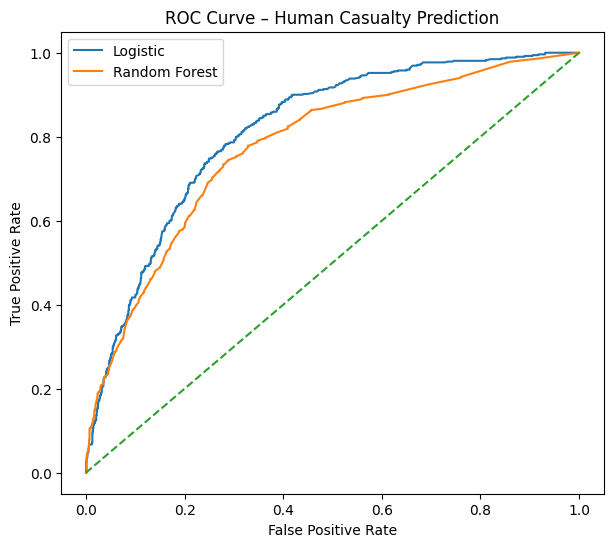

In [11]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,6))
plt.plot(fpr_log, tpr_log, label='Logistic')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Human Casualty Prediction")
plt.legend()
plt.show()


-> Là đường cong biểu diễn mối tương quan. Mô hình LOGISTIC REGRESSION tốt hơn 

Confusion Matrix

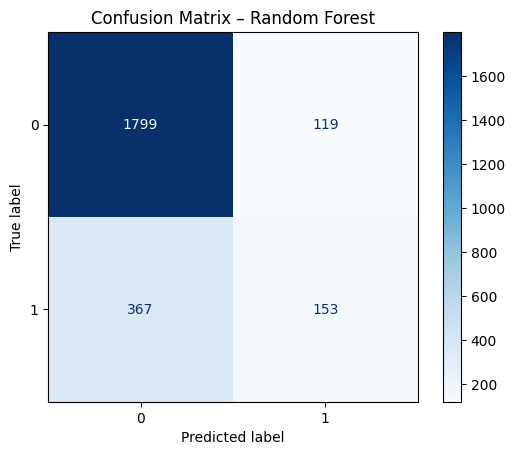

In [12]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, cmap='Blues'
)
plt.title("Confusion Matrix – Random Forest")
plt.show()


Feature Importance (Diễn giải)

In [14]:
importances = rf_model.feature_importances_
features = X_train.columns

fi = pd.Series(importances, index=features).sort_values(ascending=False).head(10)
print(fi)

admin_division_population       0.366719
country_group_united states     0.142843
month                           0.137464
landslide_size_encoded          0.063085
landslide_setting_above road    0.044570
landslide_setting_unknown       0.017978
country_group_india             0.016170
country_group_china             0.014611
landslide_trigger_Other         0.014382
landslide_category_landslide    0.014342
dtype: float64
